# Computational phenomenology of Mental Actions

Adapted from Sandved Smith et al., 2021 : *Towards a computational (neuro)phenomenology of mental action: modelling meta-awareness and attentional control with deep-parametric active inference*

Supplementary ressources : A Step-by-Step Tutorial on Active Inference and its Application to Empirical Data (Smith et al., 2022)

@author: Romy BEAUTÉ

- $O_t$ : Observable outcomes at time $t$

- $S_t$ : Hidden states at time $t$

- $π$ : Vector encoding the distribution over policies reflecting the predicted value of each policy

- $A$ matrix p($O_t$ | $S_t$ ) : encodes beliefs about the relationship between hidden states $S_t$ and observable outcomes $O_t$ at each time point $t$ => probability that specific outcomes $O$ will be observed
given specific hidden states $S$ at specific times $t$

- $B_{π,t}$ matrix $p(t+1|S_t, π)$ : encodes transition probabilities about beliefs about how hidden states will evolve over time.

In [1]:
# !pip install mne

import numpy as np
import matplotlib.pyplot as plt
from google.colab import files


def softmax(X):                                                                 ###converts log probabilities to probabilities
  norm = np.sum(np.exp(X)+10**-5)
  Y = (np.exp(X)+10**-5)/norm
  return Y

def softmax_dim2(X):                                                            ###converts matrix of log probabilities to matrix of probabilities
  norm = np.sum(np.exp(X)+10**-5,axis=0)
  Y = (np.exp(X)+10**-5)/norm
  return Y

def normalise(X):                                                               ###normalises a matrix of probabilities
  X= X/np.sum(X,0)
  return X

def normalise(X):                                                               ###normalises a matrix of probabilities
  X= X/np.sum(X,0)
  return X

### Set up model structure : deep generative model of attentional control

Figure extracted from Smith et al.,2021

Capture d’écran 2022-03-24 à 15.38.13.png

### Generative model parameters for each level

Hidden state at each level is here endowed with three levels:
- perceptual state : standard, deviant or absent
- attentional state : focused, distracted Mind Wandering (MW) or distracted Mind Blanking (MB). We characterize MB state as being deprived from perceptual posterior feedback (absence of phenomenal perceptual content)
- meta-awarness (opacity) : low, partial (without reportable content), high (with reportable content)

In [2]:
################################################################################
### Defining the Attentional states parameters
################################################################################

ADHD = False #set to True to simulate ADHD agent --> E bias towards distracted state

MB = False #set to True for distinguising MB

attentional_state = {"focus":0,"distracted":1}
attentional_state_extended = {"focus":0,"MW":1,"MB":2}

start_in_state = "focus"

if MB:
  attentional_state = attentional_state_extended

if ADHD:
  print('Simulating ADHD agent')
if MB:
  print('Distinguising Mind Blanking (absence of perceptual content)')

print('Possible attentional states (S2) : ',attentional_state)


Possible attentional states (S2) :  {'focus': 0, 'distracted': 1}


Initial distribution over policies prior to receiving an observation is given by : $$π_0 = σ(ln E − γ G)$$

In [3]:
def policy_prior(E,gammaG,G,t):
  return softmax(np.log(E)-gammaG*G[:,t])

Posterior over policies after a new observation (update) is given by : $$π = σ(ln E−F−γ G)$$

In [4]:
def policy_posterior(E,gammaG,G,t,F):
  return softmax(np.log(E)-gammaG*G[:,t-1]-F[:,t-1])

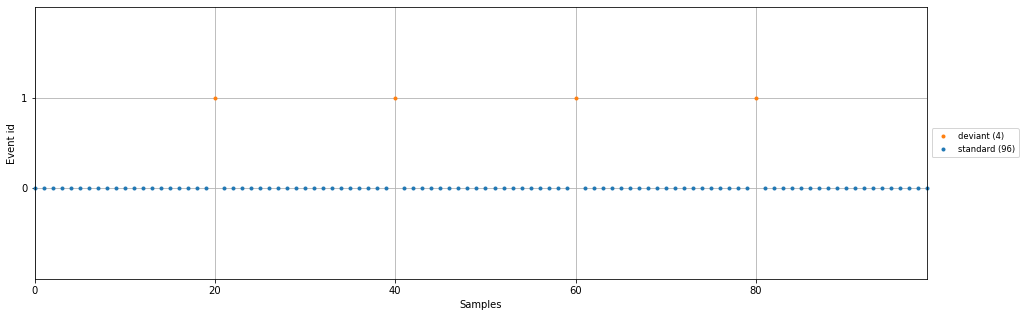

In [5]:
################################################################################
### Defining Experimental parameters
################################################################################
!pip install mne
import mne
import matplotlib

# Parameters for stimuli generation
T = 100 # number of time-steps 
n_dev = 5 # number of deviant stimuli (for the oddball paradigm)  
event_dict = {'standard': 0, 'deviant': 1}                   


# Stimuli : observations (standard vs oddball)
def stim_generation(T,n_dev):
  """generative process determined by experimenter : 0 = standard; 1 = deviant"""

  O = np.zeros(T) #define for each time point if stim is deviant or standard
  events = np.zeros((T,3)) #for plotting (clarification) purpose
  for t in range(T):
    events[t][0]=t
  for stim in range(1,n_dev):
    O[int(stim*T/n_dev)]=1 #set to deviant
    events[int(stim*T/n_dev)][2]=1 #store deviant in events array
  return O,events

   
O,events = stim_generation(T,n_dev)

#Plot the experimental events we ust generated (for clarity purposes)
matplotlib.rc('figure', figsize=(20, 5))
fig = mne.viz.plot_events(events, event_id=event_dict)
fig.subplots_adjust(right=0.7)  # make room for legend


In [6]:
#PARAMETERS LEVEL 1 : PERCEPTUAL level

### PERCEPTUAL hidden state at time T ###

S1 = np.zeros((2,T))        ### perception prior (standard vs oddball)
S1bar = np.zeros((2,T))     ### perception posterior (standard vs oddball)


### Observable PERCEPTUAL outcomes at time T ###

O1 = np.zeros((2,T))        ### observation prior (standard vs oddball)
O1bar = np.zeros((2,T))     ### observation posterior (standard vs oddball)
for t in range(T):
  O1bar[int(O[t]),t]=1

### Transition probability matrix : encoding beliefs about how PERCEPTUAL hidden states will evolve ###
B1 = np.zeros((2,2))
B1[:,0]=[0.8,0.2]
B1[:,1]=[0.2,0.8]


######## Defining PERCEPTUAL likelihood matrices  : how state map with perceptual outcome ##########

A1 = np.zeros((2,2))
A1[:,0] = [0.75,0.25]
A1[:,1] = [0.25,0.75]
gammaA1 = np.zeros(T)

betaA1m = np.zeros(2)
betaA1m[:] = [0.5,2.0]

In [7]:
#PARAMETERS LEVEL 2 : ATTENTIONAL level

Pi2 = np.zeros((2,T))       ### prior attentional actions (stay, switch)
Pi2bar = np.zeros((2,T))    ### posterior attentional actions (stay, switch)


### Prior beliefs about ATTENTIONAL policy ###
# based on the number of times different actions have been chosen in the past : 'distracted' more present in ADHD (phenotypic habit)


if not ADHD :
  E2 = np.array([0.99,0.99])    ### prior over attentional policies --> will be set bais towards distracted for ADHD condition
else:
  print('ADHD condition')
  E2 = np.array([0.8,0.6])     ### habit towards distracted state


gammaG2 = 4.0 




### Prior expectations over preferred outcomes : matrix encoding the degree to which some observed outcomes are preferred over others ###

C2 = np.array([2,-2])       ### preference over attentional outcomes (agent is trying to perform the task - ie. maintain attention on the stimulous)


### PERCEPTUAL hidden state at time T ###

S2 = np.zeros((2,T))        ### attentional states prior (high vs low precision)
S2bar = np.zeros((2,T))     ### attentional states posterior (high vs low precision)

s2 = np.zeros(T)            ### discrete generative process states --> s2 sets gammaA1
s2[0] = attentional_state[start_in_state]         ### start in a specific state
print('Start in {} state'.format(start_in_state))


u2 = np.zeros(T)            ### discrete generative process active states --> u2 sets transition probabilities for x2




### Transition probability matrix : encoding beliefs about how ATTENTIONAL hidden states will evolve ###


B2a = np.zeros((2,2))       ### maintain attentional state - "stay"
B2b = np.zeros((2,2))       ### switch atttentional state - "switch"


B2a[:,0]=[.8,0.2]           ###probability of focus/distracted, given focus+stay
B2a[:,1]=[0.0,1.0]          ###probability of focus/distracted, given distracted+stay

# if ADHD:
#   B2a[:,0]=[.7,0.3]           ###much more probability of not being able to stay focus
#   B2a[:,1]=[0.0,1.0]


B2b[:,0]=[0.0,1.0]          ###probability of focus/distracted, given focus+switch
B2b[:,1]=[1.0,0.0]          ###probability of focus/distracted, given distracted+switch

B2t = np.zeros((2,2,2))
B2t[:,:,0]=B2a
B2t[:,:,1]=B2b


######## Defining likelihood matrices for ATTENTIONAL processes ##########


A2 = np.zeros((2,2))
A2[:,0] = [0.75,0.25]
A2[:,1] = [0.25,0.75]
gammaA2 = 1.0
A2 = softmax_dim2(np.log(A2)*gammaA2)


######## Setting up F & G calculations #######

H2 = np.zeros(2)
H2[0] = np.inner(A2,np.log(A2))[0,0]
H2[1] = np.inner(A2,np.log(A2))[1,1]

G2 = np.zeros((2,T))
F2 = np.zeros((2,T)) 


O2bar = np.zeros((2,T))     ### observation posterior on the second level (focused vs distracted)

Start in focus state


In [8]:
#PARAMETERS LEVEL 3 : META-AWARENESS

S3 = np.zeros((2,T))        ### meta-awareness states prior (high vs low precision)
S3bar = np.zeros((2,T))     ### meta-awareness states posterior (high vs low precision)

S3[:,0] = [1.0,0]           ### meta-awareness state prior D3
S2[:,0] = [0.5,0.5]         ### attentional state prior D2
S1[:,0] = [0.5,0.5]         ### perceptual state prior D1

######## Defining transition matrices  ##########

B3 = np.zeros((2,2))
B3[:,0]=[.9,0.1]           ###probability of high/low meta-awareness, given high meta-awareness
B3[:,1]=[0.1,.9]          ###probability of high/low meta-awareness, given low meta-awareness

In [9]:


################################################################################
### Running the simulation 
################################################################################


# def stimulation(T,ADHD):
if ADHD:
  print('Simulating Mind-wandering during an odd-ball perceptual task in ADHD agent')
else:
  print('Simulating Mind-wandering during an odd-ball perceptual task in ADHD agent')

####### Two-level model with single factor at each level


### State belief updating 
for t in range(T):

  betaA1 = np.sum(betaA1m*np.inner(A2,S2[:,t])) # Initial prior over gamma --> Bayesian model average (prior precision beliefs)
  gammaA1[t] = betaA1m[int(s2[t])]**-1          # Confidence in current EFE estimate --> precision term, based on generative process

  A1bar = softmax_dim2(A1**gammaA1[t])          ### Precision weighted likelihood mapping
  O1[:,t] = np.inner(A1bar,S1[:,t])             ### Observation priors
  
  S1bar[:,t] = softmax(np.log(S1[:,t])+gammaA1[t]*np.log(A1[int(O[t]),:])) ## calculate perceptual state posterior

  AtC = 0                                       ### "attentional charge" - inverse precision updating term

  if not MB: #update if not in "Mind blanking" state

    for i in range(2):                            ##loop over outcomes
      for j in range(2):                          ##loop over states
        AtC += (O1bar[i,t]-A1bar[i,j])*S1bar[j,t]*np.log(A1[i,j])   
    if AtC > betaA1m[0]:
      AtC = betaA1m[0]-10**-5

  betaA1bar = betaA1 - AtC                      ## inverse precision posterior
                                                
  S2bar[:,t] = softmax(np.log(S2[:,t])-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))  ## calculate attentional state posterior given precision beliefs
  
  
### Policy selection

  if t<(T-1):
    S2a = np.inner(B2a,S2bar[:,t])
    O2a = np.inner(A2,S2a)

    S2b = np.inner(B2b,S2bar[:,t])
    O2b = np.inner(A2,S2b)
  

    G2[0,t] = np.sum(O2a*(np.log(O2a)-C2)-S2a*H2)
    G2[1,t] = np.sum(O2b*(np.log(O2b)-C2)-S2b*H2)
    #print("O2a:",O2a,"O2b:",O2b)

    #policy (π) is first selected via a softmax (normalized exponential) function (σ) of the aforementioned variables

    #STEP 1 : Initial distribution over policies prior to receiving an observation
    Pi2[:,t] = policy_prior(E2,gammaG2,G2,t)

    #STEP 2 : Generate hidden states from policy-dependent transition probabilities B
    B2 = B2a*Pi2[0,t]+B2b*Pi2[1,t] 
    S2[:,t+1] = np.inner(B2,S2bar[:,t]) ###evolve expected state
    S1[:,t+1] = np.inner(B1,S1bar[:,t])

    u2[t] = np.arange(2)[Pi2[:,t]==np.amax(Pi2[:,t])] ###generative process is discrete

    ### generative process driving attentional states

    if t<T/2:
      s2[t+1] = attentional_state[start_in_state] ##set to state
    else:
      s2[t+1] = int(not(attentional_state[start_in_state])) ##set opposit state

    


  S2abar = softmax(np.log(S2a)-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))
  S2bbar = softmax(np.log(S2b)-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))
  

  if t>0:
    F2[0,t-1] = np.sum(S2abar*(np.log(S2abar)-np.log(A2[int(s2[t]),:])-np.log(S2a)))
    F2[1,t-1] = np.sum(S2bbar*(np.log(S2bbar)-np.log(A2[int(s2[t]),:])-np.log(S2b)))
    
    #print("F2:",F2[:,t-1])

    #Posterior over policies after receiving an observation
    Pi2bar[:,t-1]=policy_posterior(E2,gammaG2,G2,t,F2)


Simulating Mind-wandering during an odd-ball perceptual task in ADHD agent


In [10]:
def S2_posterior(t):

  """ calculate attentional state posterior given precision beliefs """

  betaA1 = np.sum(betaA1m*np.inner(A2,S2[:,t])) # Initial prior over gamma --> Bayesian model average (prior precision beliefs)
  gammaA1[t] = betaA1m[int(s2[t])]**-1          # Confidence in current EFE estimate --> precision term, based on generative process

  A1bar = softmax_dim2(A1**gammaA1[t])          ### Precision weighted likelihood mapping
  O1[:,t] = np.inner(A1bar,S1[:,t])             ### Observation priors
  
  S1bar[:,t] = softmax(np.log(S1[:,t])+gammaA1[t]*np.log(A1[int(O[t]),:])) ## calculate perceptual state posterior

  AtC = 0                                       ### "attentional charge" - inverse precision updating term
  if not MB: #update if not in "Mind Blanking"
      for i in range(2):                            ##loop over outcomes
        for j in range(2):                          ##loop over states
          AtC += (O1bar[i,t]-A1bar[i,j])*S1bar[j,t]*np.log(A1[i,j])   
      if AtC > betaA1m[0]:
        AtC = betaA1m[0]-10**-5

  betaA1bar = betaA1 - AtC                      ## inverse precision posterior

  S2bar_t = softmax(np.log(S2[:,t])-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))
                                                
  return  S2bar_t, AtC, betaA1bar, betaA1

In [11]:
################################################################################
### Running the simulation 
################################################################################


def stimulation(T,ADHD):

  print('Mind-wandering during an odd-ball perceptual task')
  ####### Two-level model with single factor at each level


  ### State belief updating : attentional state posterior S2bar given precision beliefs
  for t in range(T):
    S2bar,AtC,betaA1bar,betaA1 = S2_posterior(t) 
    S2bar[:,t] = S2bar


  ### Policy selection

    if t<(T-1):
      S2a = np.inner(B2a,S2bar[:,t])
      O2a = np.inner(A2,S2a)

      S2b = np.inner(B2b,S2bar[:,t])
      O2b = np.inner(A2,S2b)

      G2[0,t] = np.sum(O2a*(np.log(O2a)-C2)-S2a*H2)
      G2[1,t] = np.sum(O2b*(np.log(O2b)-C2)-S2b*H2)

      #policy (π) is first selected via a softmax (normalized exponential) function (σ) of the aforementioned variables

      #STEP 1 : Initial distribution over policies prior to receiving an observation
      Pi2[:,t] = policy_prior(E2,gammaG2,G2,t)

      #STEP 2 : Generate hidden states from policy-dependent transition probabilities B
      B2 = B2a*Pi2[0,t]+B2b*Pi2[1,t] 
      S2[:,t+1] = np.inner(B2,S2bar[:,t]) ###evolve expected state
      S1[:,t+1] = np.inner(B1,S1bar[:,t])

      u2[t] = np.arange(2)[Pi2[:,t]==np.amax(Pi2[:,t])] ###generative process is discrete
  
      ### generative process driving attentional states
      if t<T/2:
        s2[t+1] = attentional_state[start_in_state] ##set to state
      else:
        s2[t+1] = int(not(attentional_state[start_in_state])) ##set opposit state
      

      
    S2abar = softmax(np.log(S2a)-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))
    S2bbar = softmax(np.log(S2b)-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))


    if t>0:
      F2[0,t-1] = np.sum(S2abar*(np.log(S2abar)-np.log(A2[int(s2[t]),:])-np.log(S2a)))
      F2[1,t-1] = np.sum(S2bbar*(np.log(S2bbar)-np.log(A2[int(s2[t]),:])-np.log(S2b)))

      #Posterior over policies after receiving an observation
      Pi2bar[:,t-1]=policy_posterior(E2,gammaG2,G2,t,F2) 

      return Pi2bar,u2,s2,S2bar,S1bar


Figure 1 : simulation of an active inference agent, in an oddball experimental paradigm. Look at the influence of attentional state on the perception and detection of deviant stimuli

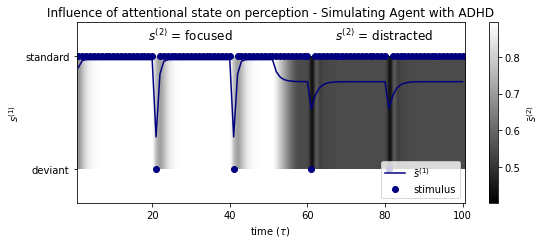

In [12]:
###Figure 1
plt.figure(figsize=(8,3.5))

plt.subplot(2,1,1)
plt.plot(1+np.arange(T),S2[0,:],label=r'${x}^{(2)}$',linestyle='--')
plt.plot(1+np.arange(T),S2bar[0,:],label=r'${\bar{x}}^{(2)}$')

plt.scatter(1+np.arange(T),1-s2,label='true state',color='black')
plt.plot(S2bar[1,:],label='distracted')

plt.ylim([-0.1,1.1])
plt.yticks([0,1],['distracted','focused'])
plt.ylabel(r'$s^{(2)}$')
plt.title('attentional state')

plt.xlim([0.5,T+0.5])

plt.subplot(1,1,1)

extent=[0.5,100.5,-0.25,1.25]
plt.imshow([S2bar[0,:],S2bar[0,:]], aspect='auto',cmap='gray',interpolation='gaussian',extent=[0.5,100.5,0,1])

plt.plot(1+np.arange(T),S1bar[0,:],label=r'${\bar{s}}^{(1)}$',color='navy')
plt.yticks([0,1],['deviant','standard'])
plt.colorbar(label=r'${\bar{s}}^{(2)}$')
plt.ylabel(r'$s^{(1)}$')
plt.xlabel(r'time ($\tau$)')
plt.scatter(1+np.arange(T),1-O,label='stimulus',color='navy')
plt.text(19,1.14,r'$s^{(2)}$ = focused',fontsize = '12')
plt.text(67,1.14,r'$s^{(2)}$ = distracted',fontsize = '12')
plt.title('Influence of attentional state on perception - Simulating Agent with ADHD')
plt.legend(loc = 'lower right')
plt.ylim([-0.3,1.3])
plt.xlim([0.5,T+0.5])


plt.tight_layout()

Figure 2 : simulation attentional cycle during oddball paradigm, in agent with and without ADHD
- Task : Mind-wandering during an odd-ball perceptual task 
- Model : Two-level model with single factor at each level

----------------------------------------------------------------------
Simulating agent in condition ADHD == True
ADHD condition
----------------------------------------------------------------------
----------------------------------------------------------------------
Simulating agent in condition ADHD == False
No ADHD condition
----------------------------------------------------------------------


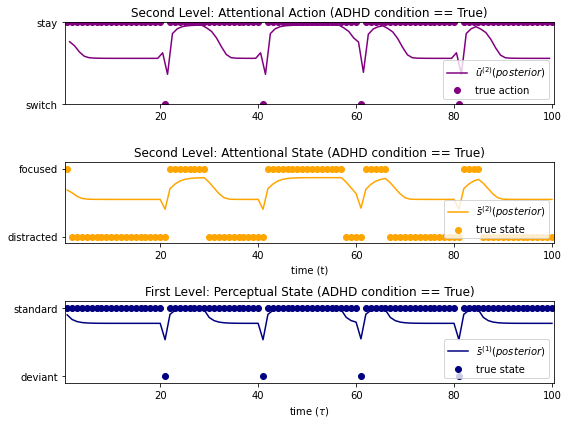

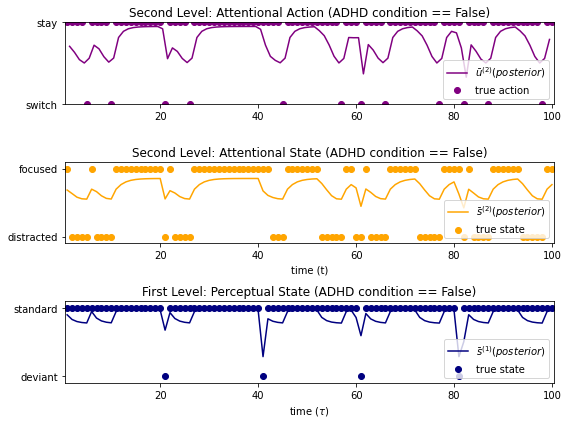

In [13]:
def run_fig2(ADHD):

  #defining parameters
  
  Pi = 2 #number of policies
  Pi2 = np.zeros((Pi,T))       ### prior attentional actions (stay, switch)
  Pi2bar = np.zeros((Pi,T))    ### posterior attentional actions (stay, switch)

  if not ADHD :
    print('No ADHD condition')
    E2 = np.array([0.99,0.99])    ### prior over attentional policies --> will be set bais towards distracted for ADHD condition
  else:
    print('ADHD condition')
    E2 = np.array([0.8,0.6])     ### habit towards distracted state


  gammaG2 = 2.0               
  C2 = np.array([2,-2])       ### preference over attentional outcomes (agent is trying to perform the task - ie. maintain attention on the stimulous)

  X3 = np.zeros((2,T))        ### meta-awareness states prior (high vs low precision)
  X3bar = np.zeros((2,T))     ### meta-awareness states posterior (high vs low precision)


  X2 = np.zeros((2,T))        ### attentional states prior (high vs low precision)
  S2bar = np.zeros((2,T))     ### attentional states posterior (high vs low precision)

  x2 = np.zeros(T)            ### discrete generative process states --> x2 sets gammaA1
  x2[0] = 0                   ### start in a focused state
  u2 = np.zeros(T)            ### discrete generative process active states --> u2 sets transition probabilities for x2


  X1 = np.zeros((2,T))        ### perception prior (standard vs oddball)
  S1bar = np.zeros((2,T))     ### perception posterior (standard vs oddball)

  O = np.zeros(T)             ### observations (standard vs oddball)

  O[int(T/5)]=1;              ### generative process determined by experimenter
  O[int(2*T/5)]=1;              ### generative process determined by experimenter
  O[int(3*T/5)]=1;              ### generative process determined by experimenter
  O[int(4*T/5)]=1;              ### generative process determined by experimenter


  O1 = np.zeros((2,T))        ### observation prior (standard vs oddball)
  O1bar = np.zeros((2,T))     ### observation posterior (standard vs oddball)
  for t in range(T):
    O1bar[int(O[t]),t]=1

  X3[:,0] = [1.0,0]           ### meta-awareness state prior D3
  X2[:,0] = [0.5,0.5]         ### attentional state prior D2
  X1[:,0] = [0.5,0.5]         ### perceptual state prior D1

  ######## Defining transition matrices  ##########

  B3 = np.zeros((2,2))
  B3[:,0]=[.9,0.1]           ###probability of high/low meta-awareness, given high meta-awareness
  B3[:,1]=[0.1,.9]          ###probability of high/low meta-awareness, given low meta-awareness


  B2a = np.zeros((2,2))       ### maintain attentional state - "stay"
  B2b = np.zeros((2,2))       ### switch atttentional state - "switch"

  B2a[:,0]=[.8,0.2]           ###probability of focus/distracted, given focus+stay
  B2a[:,1]=[0.0,1.0]          ###probability of focus/distracted, given distracted+stay

  B2b[:,0]=[0.0,1.0]          ###probability of focus/distracted, given focus+switch
  B2b[:,1]=[1.0,0.0]          ###probability of focus/distracted, given distracted+switch

  B2t = np.zeros((2,2,2))
  B2t[:,:,0]=B2a
  B2t[:,:,1]=B2b

  B1 = np.zeros((2,2))
  B1[:,0]=[0.8,0.2]
  B1[:,1]=[0.2,0.8]

  ######## Defining likelihood matrices  ##########

  A1 = np.zeros((2,2))
  A1[:,0] = [0.75,0.25]
  A1[:,1] = [0.25,0.75]
  gammaA1 = np.zeros(T)

  betaA1m = np.zeros(2)
  betaA1m[:] = [0.5,2.0]

  A2 = np.zeros((2,2))
  A2[:,0] = [0.75,0.25]
  A2[:,1] = [0.25,0.75]
  gammaA2 = 1.0
  A2 = softmax_dim2(np.log(A2)*gammaA2)

  ######## Setting up F & G calculations #######

  H2 = np.zeros(2)
  H2[0] = np.inner(A2,np.log(A2))[0,0]
  H2[1] = np.inner(A2,np.log(A2))[1,1]

  G2 = np.zeros((2,T))
  F2 = np.zeros((2,T)) 

  ################################################################################
  ### Running the simulation 
  ################################################################################

  ### State belief updating 
  for t in range(T):

    betaA1 = np.sum(betaA1m*np.inner(A2,S2[:,t])) ### Bayesian model average (prior precision beliefs)
    gammaA1[t] = betaA1m[int(s2[t])]**-1          ### actual precision is based on generative process (earlier it was betaA1**-1)

    A1bar = softmax_dim2(A1**gammaA1[t])          ### Precision weighted likelihood mapping
    O1[:,t] = np.inner(A1bar,S1[:,t])             ### Observation priors
    
    S1bar[:,t] = softmax(np.log(S1[:,t])+gammaA1[t]*np.log(A1[int(O[t]),:])) ## calculate perceptual state posterior

    AtC = 0                                       ### "attentional charge" - inverse precision updating term

    for i in range(2):                            ##loop over outcomes
      for j in range(2):                          ##loop over states
        AtC += (O1bar[i,t]-A1bar[i,j])*S1bar[j,t]*np.log(A1[i,j])   ### See "Uncertainty, epistemics and active inference" Parr, Friston.
    if AtC > betaA1m[0]:
      AtC = betaA1m[0]-10**-5

    betaA1bar = betaA1 - AtC                      ## inverse precision posterior
                                                  
    S2bar[:,t] = softmax(np.log(S2[:,t])-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))  ## calculate attentional state posterior given precision beliefs
    
    
  ### Policy selection

    if t<(T-1):
      S2a = np.inner(B2a,S2bar[:,t])
      O2a = np.inner(A2,S2a)

      S2b = np.inner(B2b,S2bar[:,t])
      O2b = np.inner(A2,S2b)
      
      #print("t:",t, "S2a:",S2a, "X2b:", X2b, "S2bar:",S2bar[:,t])

      G2[0,t] = np.sum(O2a*(np.log(O2a)-C2)-S2a*H2)
      G2[1,t] = np.sum(O2b*(np.log(O2b)-C2)-S2b*H2)
      #print("O2a:",O2a,"O2b:",O2b)
      Pi2[:,t] = softmax(np.log(E2)-gammaG2*G2[:,t])
      #print("Pi2:",Pi2[:,t],"G2:",G2[:,t])


      B2 = B2a*Pi2[0,t]+B2b*Pi2[1,t] 
      S2[:,t+1] = np.inner(B2,S2bar[:,t]) ###evolve expected state
      S1[:,t+1] = np.inner(B1,S1bar[:,t])

      u2[t] = np.arange(2)[Pi2[:,t]==np.amax(Pi2[:,t])] ###generative process is discrete
  
      ### generative process driving attentional states

      if u2[t]==0:
        s2[t+1] = np.random.choice([0,1],p=B2a[:,int(s2[t])]) ###generate true state from action 0
      else:
        s2[t+1] = np.random.choice([0,1],p=B2b[:,int(s2[t])]) ###generate true state from action 1
      


    S2abar = softmax(np.log(S2a)-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))
    X2bbar = softmax(np.log(S2b)-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))
    

    if t>0:
      F2[0,t-1] = np.sum(S2abar*(np.log(S2abar)-np.log(A2[int(s2[t]),:])-np.log(S2a)))
      F2[1,t-1] = np.sum(S2bbar*(np.log(S2bbar)-np.log(A2[int(s2[t]),:])-np.log(S2b)))
      
      #print("F2:",F2[:,t-1])
      Pi2bar[:,t-1]=softmax(np.log(E2)-gammaG2*G2[:,t-1]-F2[:,t-1])
      
  plt.figure(figsize=(8,6))
  plt.title('Influence of attentional state on perception - Simulating Agent with ADHD')
  plt.subplot(3,1,1)


  #plt.plot(1.5+np.arange(0,T-1),Pi2[0,:-1],label='stay (prior)',linestyle='--')
  #plt.plot(np.arange(1,T),Pi2[1,:-1],label='switch (prior')
  plt.plot(1.5+np.arange(0,T-1),Pi2bar[0,:-1],label=r'${\bar{u}}^{(2)}(posterior)$',color='purple')
  #plt.plot(np.arange(1,T),Pi2[1,:-1],label='switch (posterior)',linestyle='--')
  plt.scatter(1+np.arange(T),1-u2,label='true action',color='purple')
  plt.legend(loc = 'lower right')
  plt.ylim([0,1.0])
  plt.yticks([0,1],['switch','stay'])
  #plt.ylabel(r'$\pi^{(2)}$')
  plt.title('Second Level: Attentional Action (ADHD condition == {})'.format(ADHD))
  plt.xlim([0.5,T+0.5])


  plt.subplot(3,1,2)
  #plt.plot(1+np.arange(T),X2[0,:],label=r'${x}^{(2)}$',linestyle='--')
  plt.plot(1+np.arange(T),S2bar[0,:],label=r'${\bar{s}}^{(2)}(posterior)$',color='orange')
  plt.scatter(1+np.arange(T),1-s2,label='true state',color='orange')
  #plt.imshow([0.5*(1-0.5*x2),0.5*(1-0.5*x2)], aspect='auto',cmap='gray',alpha=0.3,extent=[0.5,100.5,-0.3,1.3])
  #plt.plot(S2bar[1,:],label='distracted')
  plt.ylim([-0.1,1.1])
  plt.yticks([0,1],['distracted','focused'])
  plt.xlabel('time (t)')
  #plt.ylabel(r'$x^{(2)}$')
  plt.title('Second Level: Attentional State (ADHD condition == {})'.format(ADHD))
  plt.legend(loc = 'lower right')
  plt.xlim([0.5,T+0.5])

  plt.subplot(3,1,3)
  #plt.plot(1+np.arange(T),X1[0,:],label=r'$x^{(1)}$',linestyle='--')
  plt.plot(1+np.arange(T),S1bar[0,:],label=r'${\bar{s}}^{(1)} (posterior)$',color='navy')
  plt.yticks([0,1],['deviant','standard'])
  plt.xlabel(r'time ($\tau$)')
  plt.scatter(1+np.arange(T),1-O,label='true state',color='navy')
  plt.title('First Level: Perceptual State (ADHD condition == {})'.format(ADHD))
  plt.legend(loc = 'lower right')
  plt.ylim([-0.1,1.1])
  plt.xlim([0.5,T+0.5])

  plt.tight_layout()

for adhd in [True,False]:
  print(70*'-')
  print('Simulating agent in condition ADHD ==',adhd)
  run_fig2(ADHD=adhd)
  print(70*'-')


Figure 3 : Three level model of Mind-wandering during an odd-ball perceptual task (in agent with or without ADHD)
Implementation of third level in the architecture 

----------------------------------------------------------------------
Simulating agent in condition ADHD == True
ADHD condition


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in log


----------------------------------------------------------------------
----------------------------------------------------------------------
Simulating agent in condition ADHD == False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in log


----------------------------------------------------------------------


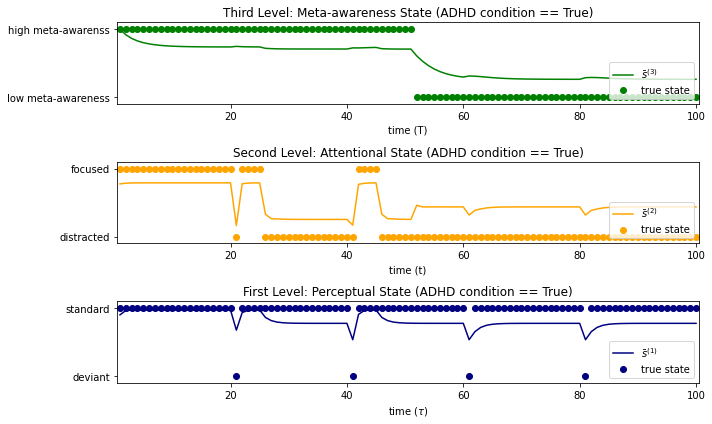

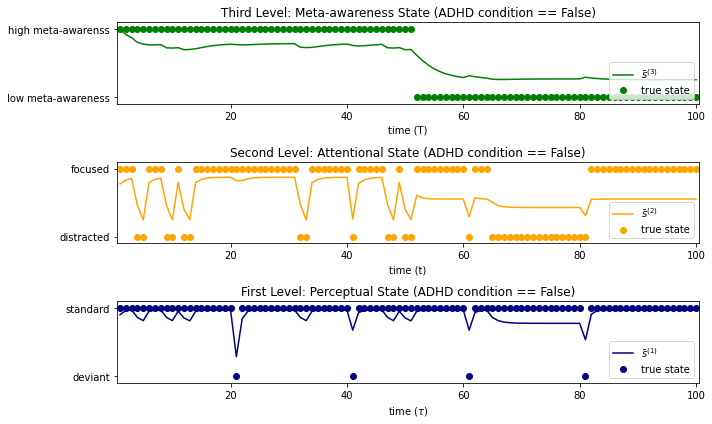

In [14]:

def run_agent(ADHD,n_fig):

  #Defining parameters
  T = 100                     ### Number of time-steps
  Pi2 = np.zeros((2,T))       ### prior attentional actions (stay, switch)
  Pi2bar = np.zeros((2,T))    ### posterior attentional actions (stay, switch)

  fig = 'fig{}'.format(n_fig)

  # E2 = np.array([0.99,0.50])    ### prior over attentional policies


  if not ADHD :
    E2 = np.array([0.99,0.40])    ### prior over attentional policies --> will be set bais towards distracted for ADHD condition
    C2 = np.array([2,-2])       ### preference over attentional outcomes (agent is trying to perform the task - ie. maintain attention on the stimulous)

  else:
    print('ADHD condition')
    E2 = np.array([0.6,0.4])     ### habit towards distracted state
    C2 = np.array([1,-.2])       ### preference over attentional outcomes (agent is trying to perform the task - ie. maintain attention on the stimulous)

  # else:
  #   print('ADHD condition')
  #   E2 = np.array([0.8,0.5])     ### habit towards distracted state
  #   C2 = np.array([2,-1])       ### preference over attentional outcomes (agent is trying to perform the task - ie. maintain attention on the stimulous)

  gammaG2 = 1.7                 #Expected Free Energy precision 

  X3 = np.zeros((2,T))        ### meta-awareness states prior (high vs low precision)
  X3bar = np.zeros((2,T))     ### meta-awareness states posterior (high vs low precision)
  x3 = np.zeros(T)            ### discrete generative process states --> x3 sets gammaA2
  x3[0] = 0                   ### start in a high meta-awareness state

  X2 = np.zeros((2,T))        ### attentional states prior (high vs low precision)
  S2bar = np.zeros((2,T))     ### attentional states posterior (high vs low precision)

  x2 = np.zeros(T)            ### discrete generative process states --> x2 sets gammaA1
  x2[0] = 0                   ### start in a focused state
  u2 = np.zeros(T)            ### discrete generative process active states --> u2 sets transition probabilities for x2


  X1 = np.zeros((2,T))        ### perception prior (standard vs oddball)
  S1bar = np.zeros((2,T))     ### perception posterior (standard vs oddball)


  O,events = stim_generation(T,n_dev)

  O1 = np.zeros((2,T))        ### observation prior (standard vs oddball)
  O1bar = np.zeros((2,T))     ### observation posterior (standard vs oddball)
  for t in range(T):
    O1bar[int(O[t]),t]=1

  O2bar = np.zeros((2,T))     ### observation posterior on the second level (focused vs distracted)


  X3[:,0] = [1,0]           ### meta-awareness state prior D3
  X2[:,0] = [0.5,0.5]         ### attentional state prior D2
  X1[:,0] = [0.5,0.5]         ### perceptual state prior D1

  ######## Defining transition matrices  ##########

  B3 = np.zeros((2,2))
  B3[:,0]=[.9,0.1]            ###probability of high/low meta-awareness, given high meta-awareness
  B3[:,1]=[0.1,.9]            ###probability of high/low meta-awareness, given low meta-awareness


  B2a = np.zeros((2,2))       ### maintain attentional state - "stay"
  B2b = np.zeros((2,2))       ### switch atttentional state - "switch"

  B2a[:,0]=[.8,0.2]           ###probability of focus/distracted, given focus+stay
  B2a[:,1]=[0.0,1.0]          ###probability of focus/distracted, given distracted+stay

  B2b[:,0]=[0.0,1.0]          ###probability of focus/distracted, given focus+switch
  B2b[:,1]=[1.0,0.0]          ###probability of focus/distracted, given distracted+switch

  B2t = np.zeros((2,2,2))
  B2t[:,:,0]=B2a
  B2t[:,:,1]=B2b

  B1 = np.zeros((2,2))
  B1[:,0]=[0.8,0.2]
  B1[:,1]=[0.2,0.8]

  ######## Defining likelihood matrices  ##########

  A1 = np.zeros((2,2))
  A1[:,0] = [0.75,0.25]
  A1[:,1] = [0.25,0.75]
  gammaA1 = np.zeros(T) #Expected Free Energy precision
  betaA1m = np.array([0.5,2.0])

  A2 = np.zeros((2,2))
  A2[:,0] = [0.65,0.35]
  A2[:,1] = [0.35,0.65]
  gammaA2 = np.zeros(T) #Expected Free Energy precision
  betaA2m = np.array([0.5,2.0])

  A3 = np.zeros((2,2))
  A3[:,0] = [0.9,0.1]
  A3[:,1] = [0.1,0.9]

  ######## Setting up F & G calculations #######

  H2 = np.zeros(2)
  H2[0] = np.inner(A2,np.log(A2))[0,0]
  H2[1] = np.inner(A2,np.log(A2))[1,1]

  G2 = np.zeros((2,T))
  F2 = np.zeros((2,T)) 

  ################################################################################
  ### Running the simulation 
  ################################################################################

  ### State belief updating 
  for t in range(T):
    ###meta-awareness level X3:
    betaA2 = np.sum(betaA2m*np.inner(A3,X3[:,t])) ### Bayesian model average (prior precision beliefs)
    gammaA2[t] = betaA2m[int(x3[t])]**-1          ### actual precision is based on generative process (earlier it was betaA2**-1)
    A2bar = softmax_dim2(np.log(A2)*gammaA2[t])
    O2bar[int(x2[t]),t]=1 ###set the true lower-level attentional states as observations to inform the meta-awareness charge

    ###attentional level X2:
    betaA1 = np.sum(betaA1m*np.inner(A2bar,X2[:,t]))  ### Bayesian model average (prior precision beliefs)
    gammaA1[t] = betaA1m[int(x2[t])]**-1              ### actual precision is based on generative process (earlier it was betaA1**-1)
    A1bar = softmax_dim2(np.log(A1)*gammaA1[t])              ### Precision weighted likelihood mapping
    
    ###perceptual level X1:
    O1[:,t] = np.inner(A1bar,X1[:,t])                                        ### Observation priors
    S1bar[:,t] = softmax(np.log(X1[:,t])+gammaA1[t]*np.log(A1[int(O[t]),:])) ## calculate perceptual state posterior


    ###calculating ascending message from X1->X2

    AtC = 0                                       ### "attentional charge" - inverse precision updating term
    for i in range(2):                            ##loop over outcomes
      for j in range(2):                          ##loop over states
        AtC += (O1bar[i,t]-A1bar[i,j])*S1bar[j,t]*np.log(A1[i,j])   ### See "Uncertainty, epistemics and active inference" Parr, Friston.
    if AtC > betaA1m[0]:
      AtC = betaA1m[0]-10**-5
    betaA1bar = betaA1 - AtC                      ## inverse precision posterior                                                
    S2bar[:,t] = softmax(np.log(X2[:,t])-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))  ## calculate attentional state posterior given precision beliefs
    
    
    S2bar[:,t] = softmax(np.log(X2[:,t])+gammaA2[t]*np.log(A2[int(x2[t]),:])-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))


    ###calculating ascending message from X2->X3
    MaC = 0                                       ### "meta-awareness charge" - inverse precision updating term
    for i in range(2):                            ##loop over outcomes
      for j in range(2):                          ##loop over states
        MaC += (O2bar[i,t]-A2bar[i,j])*S2bar[j,t]*np.log(A2[i,j])   ### See "Uncertainty, epistemics and active inference" Parr, Friston.
    if MaC > betaA2m[0]:
      MaC = betaA2m[0]-10**-5
    betaA2bar = betaA2 - MaC                      ## inverse precision posterior                                                
    X3bar[:,t] = softmax(np.log(X3[:,t])+0.1*np.log(A3[int(x3[t]),:])-1.0*np.log((betaA2m-MaC)/betaA2m*betaA2/betaA2bar))  ## calculate meta-awareness state posterior given precision beliefs
    

    
  ### Policy selection

    if t<(T-1):
      S2a = np.inner(B2a,S2bar[:,t])
      O2a = np.inner(A2,S2a)

      X2b = np.inner(B2b,S2bar[:,t])
      O2b = np.inner(A2,X2b)
      

      G2[0,t] = np.sum(O2a*(np.log(O2a)-C2)-S2a*H2)
      G2[1,t] = np.sum(O2b*(np.log(O2b)-C2)-X2b*H2)
      #print("O2a:",O2a,"O2b:",O2b)
      Pi2[:,t] = softmax(np.log(E2)-gammaG2*G2[:,t])
      #print("Pi2:",Pi2[:,t],"G2:",G2[:,t])


      B2 = B2a*Pi2[0,t]+B2b*Pi2[1,t] 
      
      X3[:,t+1] = np.inner(B3,X3bar[:,t])
      X2[:,t+1] = np.inner(B2,S2bar[:,t]) ###evolve expected state
      X1[:,t+1] = np.inner(B1,S1bar[:,t])

      u2[t] = np.arange(2)[Pi2[:,t]==np.amax(Pi2[:,t])] ###generative process is discrete
  
      ### generative process driving attentional states
      if fig=='fig1':
        if t<T/2:
          x2[t+1] = 0 ##set to focused
        else:
          x2[t+1] = 1 ##set to distracted
      else:
        if u2[t]==0:
          x2[t+1] = np.random.choice([0,1],p=B2a[:,int(x2[t])]) ###generate true state from action 0
        else:
          x2[t+1] = np.random.choice([0,1],p=B2b[:,int(x2[t])]) ###generate true state from action 1

      if fig=='fig3':
        if t<T/2: 
          x3[t+1]=0
        else:
          x3[t+1]=1
      else:
        x3[t+1] = np.random.choice([0,1],p=B3[:,int(x3[t])]) ###generate true state



    S2abar = softmax(np.log(S2a)-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))
    X2bbar = softmax(np.log(X2b)-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))
    

    if t>0:
      F2[0,t-1] = np.sum(S2abar*(np.log(S2abar)-np.log(A2[int(x2[t]),:])-np.log(S2a)))
      F2[1,t-1] = np.sum(X2bbar*(np.log(X2bbar)-np.log(A2[int(x2[t]),:])-np.log(X2b)))
      
      #print("F2:",F2[:,t-1])
      Pi2bar[:,t-1]=softmax(np.log(E2)-gammaG2*G2[:,t-1]-F2[:,t-1])


  ################################################################################
  ### Plotting results
  ################################################################################


  plt.figure(figsize=(10,6))

  plt.subplot(3,1,1)
  plt.plot(1+np.arange(T),X3bar[0,:],label=r'${\bar{s}}^{(3)}$',color='green')
  plt.scatter(1+np.arange(T),1-x3,label='true state',color='green')
  plt.ylim([-0.1,1.1])
  plt.yticks([0,1],['low meta-awareness','high meta-awarenss'])
  plt.xlabel('time (T)')
  plt.title('Third Level: Meta-awareness State (ADHD condition == {})'.format(ADHD))
  plt.legend(loc = 'lower right')
  plt.xlim([0.5,T+0.5])

  plt.subplot(3,1,2)
  plt.plot(1+np.arange(T),S2bar[0,:],label=r'${\bar{s}}^{(2)}$',color='orange')
  plt.scatter(1+np.arange(T),1-x2,label='true state',color='orange')

  plt.ylim([-0.1,1.1])
  plt.yticks([0,1],['distracted','focused'])
  plt.xlabel('time (t)')
  plt.title('Second Level: Attentional State (ADHD condition == {})'.format(ADHD))
  plt.legend(loc = 'lower right')
  plt.xlim([0.5,T+0.5])

  plt.subplot(3,1,3)
  plt.plot(1+np.arange(T),S1bar[0,:],label=r'${\bar{s}}^{(1)}$',color='navy')
  plt.yticks([0,1],['deviant','standard'])
  plt.xlabel(r'time ($\tau$)')
  plt.scatter(1+np.arange(T),1-O,label='true state',color='navy')
  plt.title('First Level: Perceptual State (ADHD condition == {})'.format(ADHD))
  plt.legend(loc = 'lower right')
  plt.ylim([-0.1,1.1])
  plt.xlim([0.5,T+0.5])

  return plt

  # plt.tight_layout()

for adhd in [True,False]:
  print(70*'-')
  print('Simulating agent in condition ADHD ==',adhd)
  plt = run_agent(ADHD=adhd,n_fig=3)
  plt.tight_layout()
  print(70*'-')
